In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [10]:
def get_pickles(): 
    x_train = pickle.load(open(f'../../data/processed/pickles/cluster_x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/cluster_x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/cluster_y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/cluster_y_test.p', 'rb'))
    X = pickle.load(open('../../data/processed/pickles/cluster_X.p', 'rb'))
    y = pickle.load(open('../../data/processed/pickles/cluster_y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles()

print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')





standard = StandardScaler() 
x_train[['amount_tsh', 'gps_height', 
         'population', 'time_passed']] = standard.fit_transform(x_train[['amount_tsh', 
                                                                         'gps_height', 'population', 'time_passed']])
unique_clusters = x_train.cluster.unique() 
complete_x = x_train.append(x_test, ignore_index = False)
complete_y = y_train.append(y_test, ignore_index = False)
complete_df = complete_x
complete_df['target'] = complete_y.target.values

y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

Original X: (57247, 55)	Original y: (57247, 1)
Train X: (42935, 54)	Train y: (42935, 1)
Test X: (14312, 54)	Test y: (14312, 1)


In [44]:
X['target'] = y
x_test['target'] = y_test
x_train['target'] = y_train

### Baseline Testing for Models and Stacked

In [13]:

models = {'log': LogisticRegression(),
          'knn': KNeighborsClassifier(),
          'dt': DecisionTreeClassifier(), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
          'rf': RandomForestClassifier(),
        }
#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model
unique_clus = list(enumerate(unique_clusters))
pbar = tqdm(unique_clus)
final_results = {}
for idx, clus in pbar:
    #test each model and stacking
    results = []
    model_names = []
    for idx2, (model, m) in enumerate(models.items()): 
        pbar.set_description(f'({idx}/{len(unique_clusters)}){clus}: Evaluating {model.upper()} {idx2}/{len(models)}')
        cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5, random_state = 10)
        y_region = complete_df[complete_df.cluster==clus].target.values
        x_region = complete_df[complete_df.cluster == clus].drop(['cluster', 'target'], axis =1)
        scores = cross_val_score(m, x_region, y_region, scoring = 'accuracy', cv = cv, n_jobs = 12, 
                                 error_score = 'raise')
        results.append(scores)
        model_names.append(model)
    final_results[clus] = {'results': results, 'model_names': model_names}

    

(9/21)7: Evaluating STACKED 6/7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:19<00:00, 37.98s/it]


In [14]:
pickle.dump(final_results, open('../../models/ByClusterVanillaResults.p', 'wb'))
final_results

{3: {'results': [array([0.74358974, 0.72649573, 0.68803419, 0.72008547, 0.72805139,
          0.68308351, 0.72376874, 0.72591006, 0.75802998, 0.68736617,
          0.71153846, 0.72863248, 0.72863248, 0.71153846, 0.7130621 ,
          0.72805139, 0.67880086, 0.70235546, 0.73233405, 0.70449679,
          0.74358974, 0.71153846, 0.69871795, 0.69444444, 0.72805139,
          0.7366167 , 0.68736617, 0.71520343, 0.72591006, 0.69164882,
          0.71153846, 0.72222222, 0.7457265 , 0.67307692, 0.71734475,
          0.73875803, 0.72805139, 0.68308351, 0.70021413, 0.70235546,
          0.71794872, 0.70512821, 0.73290598, 0.72008547, 0.72162741,
          0.7130621 , 0.70877944, 0.70021413, 0.74732334, 0.74089936]),
   array([0.75854701, 0.77564103, 0.77564103, 0.75      , 0.75374732,
          0.74732334, 0.74732334, 0.75588865, 0.77301927, 0.74518201,
          0.76068376, 0.76068376, 0.7542735 , 0.73717949, 0.79229122,
          0.74946467, 0.71948608, 0.76017131, 0.73875803, 0.76445396,
    

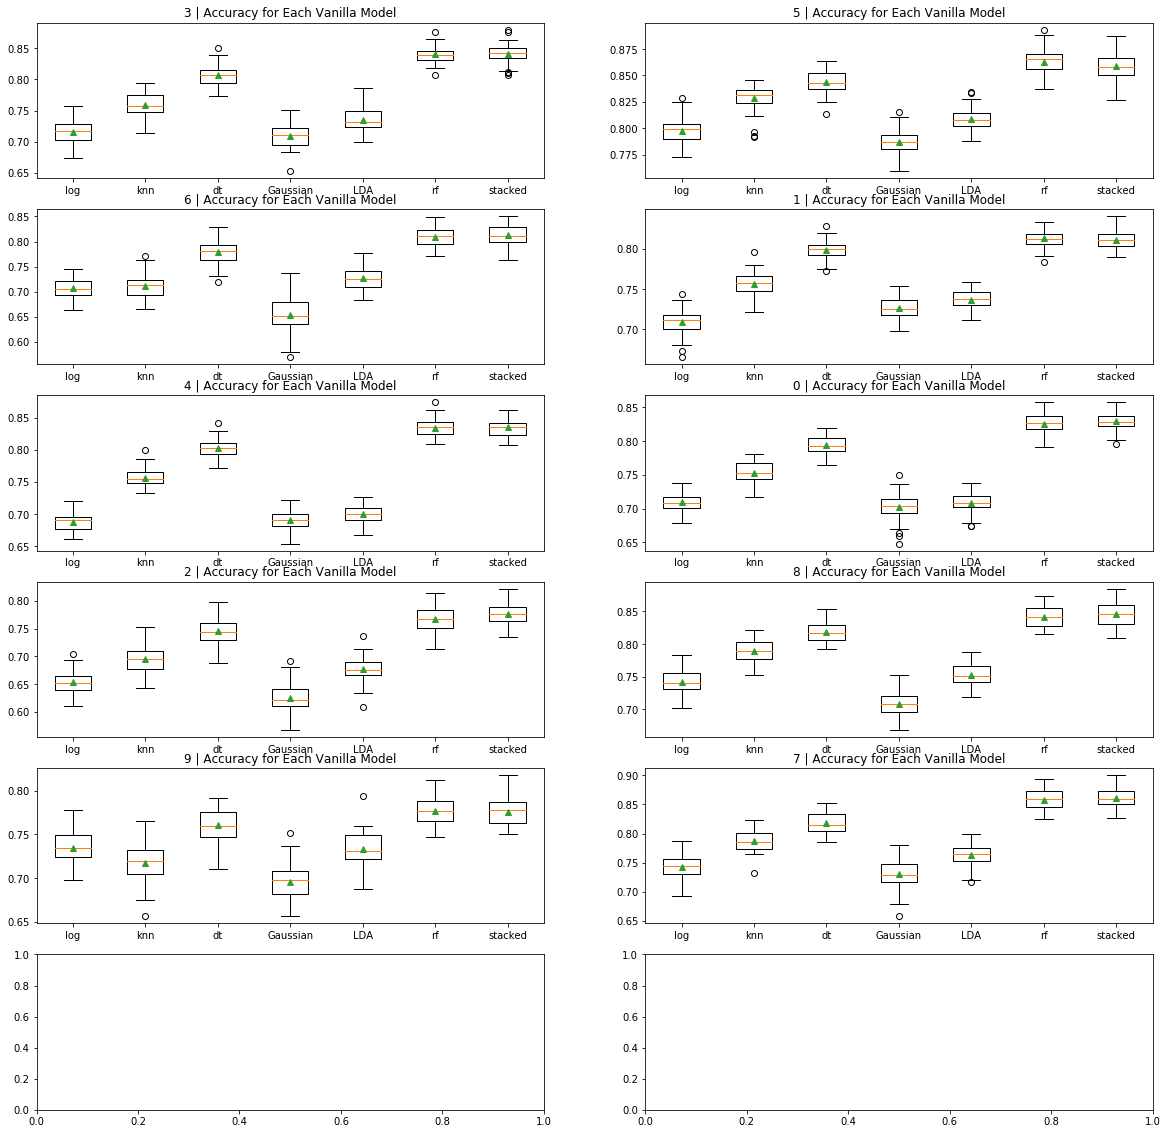

In [16]:
fig, ax =plt.subplots(len(final_results)//2+1, 2, figsize = (20,20))

for i, clus in enumerate(final_results.keys()): 
    results = final_results[clus]['results']
    model_names = final_results[clus]['model_names']
    idx1 = i //2
    idx2 = i % 2
#     print(idx1, idx2)
    ax[idx1, idx2].boxplot(results, labels = model_names, showmeans = True)
    ax[idx1, idx2].set_title(f'{clus} | Accuracy for Each Vanilla Model')
#     ax[idx1, idx2].set_ylabel('Accuracy')
#     ax[idx1, idx2].set_xlabel('Model')
    
    


In [50]:
iringa_df_train = x_train[x_train.region == 'Iringa']
iringa_x_train = iringa_df_train[[i for i in x_train.columns if i not in ['target', 'region']]]
iringa_y_train = iringa_df_train[['target']].values.ravel()

iringa_df_test = x_test[x_test.region == 'Iringa']
iringa_x_test = iringa_df_test[[i for i in x_test.columns if i not in ['target', 'region']]]
iringa_y_test = iringa_df_test[['target']].values.ravel()

iringa_x_train
log = LogisticRegression(max_iter = 5000)
log.fit(iringa_x_train, iringa_y_train)
print(log.score(iringa_x_test,iringa_y_test))

0.7827743902439024


In [51]:

print(iringa_df_train.shape) 
iringa_df_test.shape

(3936, 55)


(1312, 55)

In [57]:
iringa_df_train = x_train[x_train.region == 'Mtwara']
iringa_x_train = iringa_df_train[[i for i in x_train.columns if i not in ['target', 'region']]]
iringa_y_train = iringa_df_train[['target']].values.ravel()

iringa_df_test = x_test[x_test.region == 'Mtwara']
iringa_x_test = iringa_df_test[[i for i in x_test.columns if i not in ['target', 'region']]]
iringa_y_test = iringa_df_test[['target']].values.ravel()

iringa_x_train
log = RandomForestClassifier()
log.fit(iringa_x_train, iringa_y_train)
print(log.score(iringa_x_test,iringa_y_test))

0.7692307692307693
